# CGAN

*Conditional GAN*

条件付きGAN。与えた条件に沿った画像を生成する。  

In [ ]:
%cd

C:\Users\user


In [1]:
# パッケージのimport
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from IPython.display import display
from typing import List, Tuple

# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

num_try = 16 # 試行回数

nz = 40
noise_std = 0.4
dropout_ratio = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# for google colab

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/GenerativeAI/"

# for local runtime
# path = "./Desktop/generative_ai/"

Mounted at /content/drive


## Dataloaderの作成

In [3]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(50):
        img_path = path + "data/hem_crp/hemangioma_" + str(img_idx)+'.png'
        train_img_list.append({"data":img_path, "label":0})

        img_path = path + "data/met_crp/metastasis_" + str(img_idx)+'.png'
        train_img_list.append({"data":img_path, "label":1})

    return train_img_list

def make_datapath_list_catdog():
  """catdogで事前学習用のデータセットを作成する。 """

  train_img_list = list()  # 画像ファイルパスを格納

  for img_idx in range(1000):
    img_path = path + "Integrated-Design-Diffusion-Model/datasets/cat_dog/class_0/cat_" + str(img_idx) + ".png"
    train_img_list.append({"data":img_path, "label":0})

    img_path = path + "Integrated-Design-Diffusion-Model/datasets/cat_dog/class_1/dog_" + str(img_idx) + ".png"
    train_img_list.append({"data":img_path, "label":1})

  return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=(-90, 90)),
            # transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, datalist, transform):
        self.transform = transform
        self.datalist = datalist

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        datapath = self.datalist[index]["data"]
        label = self.datalist[index]["label"]

        img = Image.open(datapath)

        # データの変形 (transforms)
        img_transformed = self.transform(img)

        return img_transformed, label

    def __len__(self) -> int:
        return len(self.datalist)

mean = (0.5,)
std = (0.5,)
batch_size = 25

dataset = GAN_Img_Dataset(
    datalist=make_datapath_list_catdog(), # pre_train --> make_datapath_list_catdog()
    transform=ImageTransform(mean, std)
)

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True
)

# 動作の確認
sample_x, _ = next(iter(train_dataloader))
n_classes = 2 # hem: 0, met: 1の2クラス
w, h = sample_x.shape[-2:]
image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)
print("num classes:", n_classes)

batch shape: torch.Size([25, 1, 64, 64])
width: 64
height: 64
image size: 4096
num classes: 2


## 条件の埋め込み

条件の情報をノイズに埋め込む。対応する部分だけ少し大きな値をとるようにした。

In [4]:
eye = torch.eye(n_classes, device=device)
def make_noise(labels):
    labels = eye[labels]
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    return z

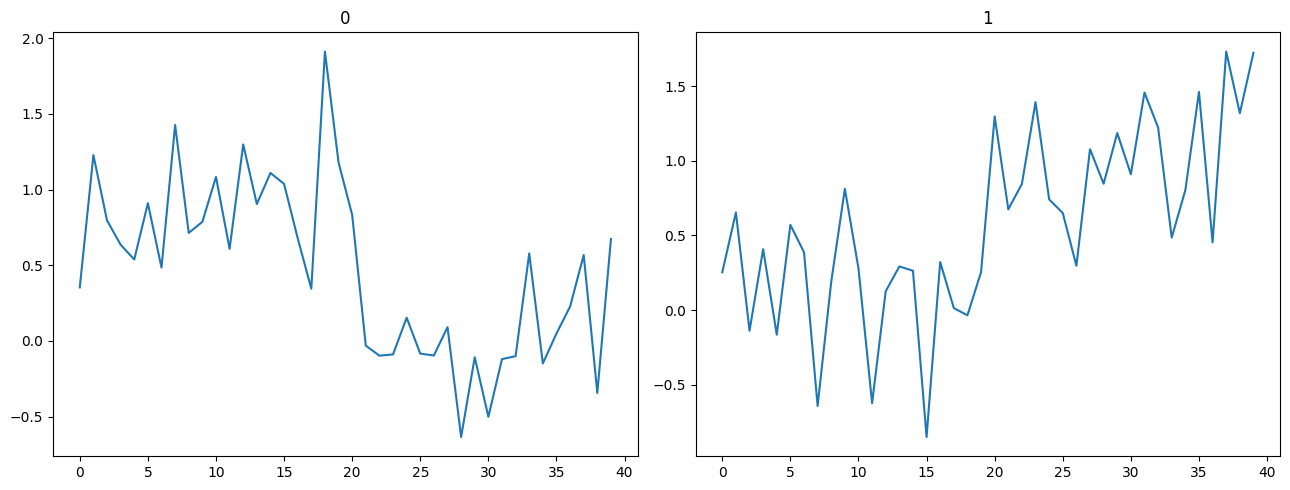

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for label in range(n_classes):
    plt.subplot(1, 2, label+1)
    vec = make_noise(torch.tensor([label])).cpu().numpy().ravel()
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

## 学習

In [6]:
# 画像描画
def write(netG, n_rows=1, size=64):
    n_images = n_rows * n_classes
    z = make_noise(torch.tensor(list(range(n_classes)) * n_rows))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_images // n_rows)
    img = transforms.functional.to_pil_image(img)
    display(img)

# 間違ったラベルの生成
def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [7]:
# ラベルにノイズをのせる --> Generatorに有利
def make_labels_noisy(labels, true=True):
    low, high = 7, 12
    if true == False:
        low, high = 0, 3
    noise = torch.randint(low=low, high=high, size=labels.shape, device=device) / 10
    noisy_labels = torch.mul(labels, noise)
    return noisy_labels

In [8]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(reduction='mean')

# lossを記録
lossD_list = list()
lossG_list = list()

def train(netD, netG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    # optimizerを選択
    # g_lr, d_lr = 0.0001, 0.0004
    # beta1, beta2 = 0.0, 0.9
    # optimD = optim.Adam(netD.parameters(), d_lr, [beta1, beta2])
    # optimG = optim.Adam(netG.parameters(), g_lr, [beta1, beta2])


    for epoch in range(1, n_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        i = 0
        for X, labels in train_dataloader:
            X = X.to(device) # 本物の画像
            labels = labels.flatten()
            labels = labels.to(device) # 正しいラベル
            false_labels = make_false_labels(labels) # 間違ったラベル

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習

            z = make_noise(labels) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake, labels, true=True) # 偽物を判定
            pred_real_true = netD(X, labels, true=True) # 本物&正しいラベルを判定
            pred_real_false = netD(X, false_labels, true=False) # 本物&間違ったラベルを判定
            # 誤差を計算
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)
            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward() # 逆伝播
            if i % 2 == 0: # Discriminatorは2回に1回だけ更新
                optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake, labels) # 偽物を判定
            lossG = criterion(pred, real_labels) # 誤差を計算
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

            i += 1

        lossD_list.append(lossD / batch_size)
        lossG_list.append(lossG / batch_size)

        t_epoch_finish = time.time()
        print('-------------')
        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # モデルの保存
        if epoch % 100 == 99:
          save_path_G = path + "CDCGAN/model/netG_{}_{}.cpt".format(num_try, epoch)
          save_path_D = path + "CDCGAN/model/netD_{}_{}.cpt".format(num_try, epoch)
          torch.save({'epoch': epoch,
                      'model_state_dict': netG.state_dict(),
                      'optimizer_state_dict': optimG.state_dict(),
                      'loss': lossG_list,},
                    save_path_G)
          torch.save({'epoch': epoch,
                      'model_state_dict': netD.state_dict(),
                      'optimizer_state_dict': optimD.state_dict(),
                      'loss': lossD_list,},
                    save_path_D)

        if write_interval and epoch % write_interval == 0:
            write(netG)

## CDCGAN

*Conditional Deep Convolitional GAN*

条件付きDCGAN。GeneratorとDiscriminatorにCNNを使うだけ。画像がきれいになることを期待する。

### Discriminator

畳み込みで得た特徴ベクトルに、ラベル（条件）のone-hotベクトルを結合して、全結合層に入力する。

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self._conv_layer(1, w, 4, 2, 1),
            self._conv_layer(w, w*2, 4, 2, 1),
            self._conv_layer(w*2, w*4, 4, 2, 1),
            self._conv_layer(w*4, w*8, 4, 2, 1),
            nn.Conv2d(w*8, 128, 4, 1, 0),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 + n_classes, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._eye = torch.eye(n_classes, device=device) # 条件ベクトル生成用の単位行列

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p=dropout_ratio)
        )

    def forward(self, x, labels, true=True):
        x = self.conv(x) # 特徴抽出
        labels = labels.flatten()
        labels = self._eye[labels] # 条件(ラベル)をone-hotベクトルに
        labels = make_labels_noisy(labels, true=true)
        x = torch.cat([x, labels], dim=1) # 画像と条件を結合
        y = self.fc(x)
        return y

### Generator

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, w*8, 4, 1, 0),
            self._convT(w*8, w*4, 4, 2, 1),
            self._convT(w*4, w*2, 4, 2, 1),
            self._convT(w*2, w, 4, 2, 1),
            nn.ConvTranspose2d(w, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p=0)
        )

    def forward(self, x):
        x = x.view(-1, nz, 1, 1)
        y = self.net(x)
        return y

### 学習

初期状態


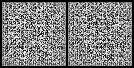

In [ ]:
# modelを規定
netD = Discriminator().to(device)
netG = Generator().to(device)

# optimizerを選択
g_lr, d_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9
optimG = optim.Adam(netG.parameters(), g_lr, [beta1, beta2])
optimD = optim.Adam(netD.parameters(), d_lr, [beta1, beta2])


n_epochs = 1000

print('初期状態')
write(netG)
start = time.time()
train(netD, netG, n_epochs, 100)
end = time.time()
print("学習時間：{}".format(end - start))

In [ ]:
# 学習の再開
call_epoch = 999 # 再開するエポック

## modelの規定
netD = Discriminator().to(device)
netG = Generator().to(device)

## optimizerの選択
g_lr, d_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9
optimG = optim.Adam(netG.parameters(), g_lr, [beta1, beta2])
optimD = optim.Adam(netD.parameters(), d_lr, [beta1, beta2])

## 読み出し

cptfileG = path + 'CDCGAN/model/netG_{}_{}.cpt'.format(num_try, call_epoch)
### model, optimizer, lossを読み出す
cptG = torch.load(cptfileG)
stdict_m_G = cptG['model_state_dict']
stdict_o_G = cptG['optimizer_state_dict']
stdict_l_G = cptG['loss']
netG.load_state_dict(stdict_m_G)
optimG.load_state_dict(stdict_o_G)
lossG_list = stdict_l_G

cptfileD = path + 'CDCGAN/model/netD_{}_{}.cpt'.format(num_try, call_epoch)
cptD = torch.load(cptfileD)
stdict_m_D = cptD['model_state_dict']
stdict_o_D = cptD['optimizer_state_dict']
stdict_l_D = cptD['loss']
netD.load_state_dict(stdict_m_D)
optimD.load_state_dict(stdict_o_D)
lossD_list = stdict_l_D

# n_epochs = 1000 # あとn_epochsだけ学習を進める

# print('初期状態')
# write(netG)
# start = time.time()
# train(netD, netG, n_epochs, 100)
# end = time.time()
# print("学習時間：{}".format(end - start))

In [ ]:
# lossのプロット
x = np.arange(1, n_epochs+1)
plt.plot(x, lossD_list, color="grey", label="D")
plt.plot(x, lossG_list, color="black", label="G")
plt.legend()
plt.savefig(path + "CDCGAN/loss/loss_0{}.png".format(num_try))

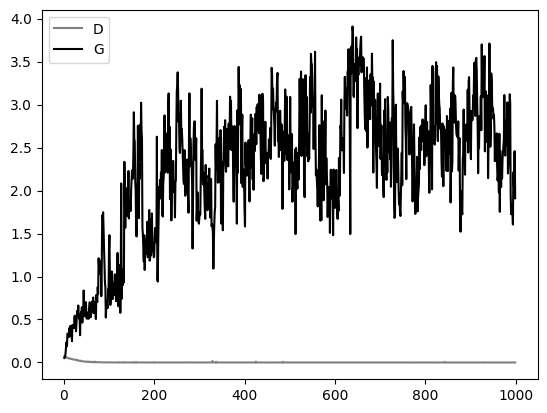

In [ ]:
lossD_list = [x.to('cpu').detach().numpy().copy() for x in lossD_list]
lossG_list = [x.to('cpu').detach().numpy().copy() for x in lossG_list]

# lossのプロット
x = np.arange(1, n_epochs+1)
plt.plot(x, lossD_list, color="grey", label="D")
plt.plot(x, lossG_list, color="black", label="G")
plt.legend()
plt.savefig(path + "CDCGAN/loss/loss_0{}.png".format(num_try))

In [ ]:
write(netG, 10) # 腫瘍画像を10セット描画
plt.savefig(path + "CDCGAN/product/product_0{}_{}.png".format(num_try, n_epochs))

In [ ]:
def write_from_label(netG, label, n_images=10, size=64):
    # labelに応じて腫瘍画像を描画
    labels = torch.tensor([label]*n_images).to(device)
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, len(z))
    img = transforms.functional.to_pil_image(img)
    display(img)

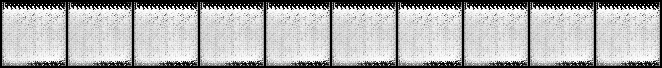

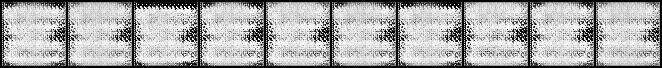

In [ ]:
label = [0, 1] # metastasis
write_from_label(netG, label)
label = [1, 0] # hemangioma
write_from_label(netG, label)